In [1]:
import numpy as np
import json
import pandas as pd
from utils import Timer
from joblib import Parallel, delayed
from traj2grid import Traj2Grid
import traj_dist.distance as tdist
from parameters import *
import numpy as np


#### 读取数据


In [2]:
timer = Timer()

file_path = "data/full/gps_20161101"
dict_path = "data/str_grid2idx_200_19227.json"
nrows = 1000000
vocab_size = 200


# read data
timer.tik("read data")
df = pd.DataFrame(pd.read_csv(file_path, names=["name", "id", "time", "lon", "lat"],
        usecols=["id", "lon", "lat"], nrows=nrows))
# df.columns = ["name", "id", "time", "lon", "lat"]  # lon经度 lat纬度
timer.tok("read {}".format(file_path))


read data start
read data/full/gps_20161101 done, 0.601s after read data start


0.6015732288360596

#### 去除超出范围的数据点


In [3]:
pad = 0.002


l = len(df)
df = df[(df["lon"] > 104.04214 + pad) & (df["lon"] < 104.12958 - pad)]
df = df[(df["lat"] > 30.65294 + pad) & (df["lat"] < 30.72775 - pad)]
print(f"剩{len(df)}/{l}个点，筛掉{round(100 - 100 * len(df) / l)}%")


剩948146/1000000个点，筛掉5%


#### GroupBy转换为1维点列

In [4]:
str_grid2idx = json.load(open(dict_path))
t2g = Traj2Grid(row_num, column_num, min_lon, min_lat, max_lon, max_lat)
grid2idx = {eval(g): str_grid2idx[g] for g in list(str_grid2idx)}
t2g.set_vocab(grid2idx)
timer.tok(f"load dict{dict_path}")


def group_concat(group: pd.DataFrame):
    origin_traj = [((row["lon"]), row["lat"])
                   for index, row in group.iterrows()]
    traj_1d, coord_traj = t2g.convert1d(origin_traj)
    series = pd.Series({
        "origin_trajs": coord_traj,
        "trajs": traj_1d,
        "len": len(traj_1d),
        "max_lon": group["lon"].max(),
        "max_lat": group["lat"].max(),
        "min_lon": group["lon"].min(),
        "min_lat": group["lat"].min(),
    })
    return series


# group-apply
# res = []
# for name, group in df.groupby("id"):
#     res.append(group_concat(group))
res = Parallel(n_jobs=44)(delayed(group_concat)(group)for name, group in df.groupby("id"))
df = pd.DataFrame(res)
timer.tok("group-apply")


load dictdata/str_grid2idx_200_19227.json done, 0.883s after read data start
group-apply done, 26.84s after read data start


26.840320587158203

##### 看看数据情况

count    5485.000000
mean       20.022789
std        25.441980
min         0.000000
25%         0.000000
50%         7.000000
75%        36.000000
max       145.000000
Name: len, dtype: float64

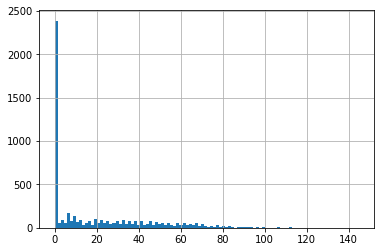

In [5]:
df['len'].hist(bins=100)
df['len'].describe()

#### 过滤过长过短轨迹

In [6]:
dff = df[(df["len"] > 0) & (df["len"] < 999)]
print(f"剩{len(dff)}/{len(df)}条轨迹，筛掉{round(100 - 100 * len(dff) / len(df))}%")


剩3140/5485条轨迹，筛掉43%


#### 生成pair-wise轨迹距离矩阵


In [7]:
# dff = dff.reset_index()
origin_trajs = dff["origin_trajs"].to_list()
arr = [np.array(origin_traj) for origin_traj in origin_trajs]
length = len(arr)
dis_matrix = np.zeros((length, length))
dis_func = getattr(tdist, "discret_frechet")


def cal_dis(i, j, x, y, n):
    dis = dis_func(x, y)
    if i == j + 1 and i % 100 == 1:
        timer.tok(f'{i}-{round((i * i) / (n * n) * 100, 2)}%')
    return i, j, dis

res = Parallel(n_jobs=44)(
    delayed(cal_dis)(i, j, arr[i], arr[j], length - 1) for i in range(length) for j in range(i))
timer.tok("calculate distance")
for (i, j, dis) in res:
    dis_matrix[i,j] = dis
    dis_matrix[j,i] = dis


1-0.0% done, 27.994s after read data start
101-0.1% done, 28.504s after read data start
201-0.41% done, 29.007s after read data start
301-0.92% done, 29.715s after read data start
401-1.63% done, 30.765s after read data start
501-2.55% done, 31.964s after read data start
601-3.67% done, 33.498s after read data start
701-4.99% done, 35.359s after read data start
801-6.51% done, 37.413s after read data start
901-8.24% done, 39.662s after read data start
1001-10.17% done, 42.342s after read data start
1101-12.3% done, 45.224s after read data start
1201-14.64% done, 48.505s after read data start
1301-17.18% done, 52.022s after read data start
1401-19.92% done, 55.865s after read data start
1501-22.87% done, 59.922s after read data start
1601-26.01% done, 64.32s after read data start
1701-29.36% done, 69.269s after read data start
1801-32.92% done, 73.801s after read data start
1901-36.68% done, 79.302s after read data start
2001-40.64% done, 84.679s after read data start
2101-44.8% done, 9

#### 生成 Train Dataset 第六步：保存

In [8]:

file_name = file_path.split("/")[-1]
save_path = "data/train/"
file_path = save_path + file_name
sorted_index = np.argsort(dis_matrix, axis=1)
dict_save = {'trajs': dff["trajs"].to_list(), 'origin_trajs': origin_trajs}
dict_save["dis_matrix"] = dis_matrix.tolist()
json.dump(dict_save, open(file_path + f"_{sorted_index.shape[0]}_{vocab_size}_dataset_full.json", "w"))
timer.tok("save")


save done, 183.96s after read data start


183.96047401428223